In [455]:
import pandas as pd
import numpy as np
import os
import folium
from folium import plugins
import webbrowser
from collections import Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats
from scipy.stats import geom
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [419]:
sp_data = pd.read_csv('singapore_listings.csv')
print(sp_data.shape)
sp_data.head()

(7907, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,9,353
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,9,355


In [420]:
price = sp_data['price'].values
print(f'maximum of price: {max(price)}, <= 98% price value: {sorted(price)[round(len(price)*0.98)]}')

maximum of price: 10000, <= 98% price value: 581


In [421]:
def filter_abnormal(sp_data):
    price = sp_data['price'].values
    pos = np.where(price > 500)
    sp_data = sp_data.drop(pos[0])
    return sp_data

In [422]:
sp_data = filter_abnormal(sp_data) # filter abnormal datapoints
sp_data.shape

(7709, 16)

In [469]:
def fitting_freq_curve(price, xlabel, ylabel, bins, x_min=min, x_max=max, func='Gamma'):
    n, bins, patches = plt.hist(price,bins,density=True)
    if func == 'Gamma':
        xt = plt.xticks()[0]  
        xmin, xmax = min(xt), max(xt)  
        lnspc = np.linspace(xmin, xmax, len(price))

        ag, bg, cg = stats.gamma.fit(price)  
        pdf_gamma = stats.gamma.pdf(lnspc, ag, bg,cg)  
        plt.plot(lnspc, pdf_gamma, label="Gamma", color='r')

    xmin1 = x_min if type(x_min) in [int,float] else x_min(price)
    xmax1 = x_max if type(x_max) in [int,float] else x_max(price)
    
    plt.xlim(xmin1,xmax1)
    plt.title('distribution of '+xlabel+' '+ylabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [424]:
def calculate_distribution(price):
    mean_price = np.mean(price)
    print(f'mean value: {mean_price}')
    over_price = sum(price>mean_price)/len(price)
    lower_price = sum(price<=mean_price)/len(price)
    print(f'over average percentage: {round(over_price*100,2)}%')
    print(f'lower average percentage: {round(lower_price*100,2)}%')

## Feature frequency and its domestic distribution

mean value: 140.61512517836294
over average percentage: 39.45%
lower average percentage: 60.55%


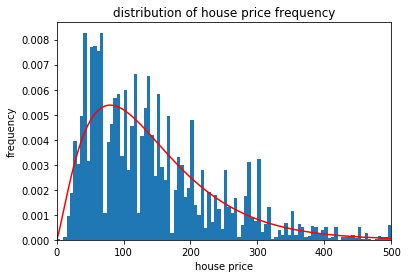

In [553]:
price = sp_data['price'].values
calculate_distribution(price)
fitting_freq_curve(price, 'house price', 'frequency', 100)

In [426]:
lat = sp_data['latitude'].values
lon = sp_data['longitude'].values

mean value: 1.3143900492930343
over average percentage: 38.75%
lower average percentage: 61.25%


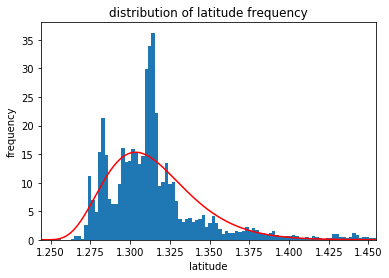

In [492]:
calculate_distribution(lat)
fitting_freq_curve(lat, 'latitude', 'frequency',100)

mean value: 103.84890921131147
over average percentage: 51.24%
lower average percentage: 48.76%


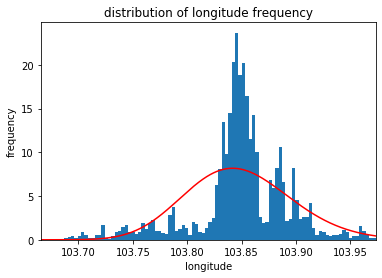

In [428]:
calculate_distribution(lon)
fitting_freq_curve(lon, 'longitude', 'frequency',100)

##### the first three can nearly be regarded as Poisson distribution

Text(0.5, 1.0, 'domesitc distribution of price')

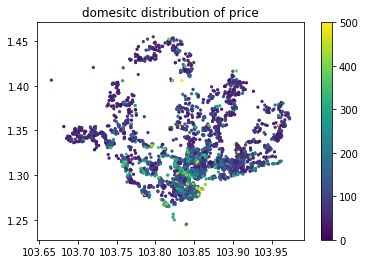

In [486]:
plt.scatter(lon, lat, c=price, s=5)
plt.colorbar()
plt.title('domesitc distribution of price')

In [453]:
mn = sp_data['minimum_nights'].values
avl = sp_data['availability_365'].values

mean value: 17.516409391620183
over average percentage: 21.84%
lower average percentage: 78.16%


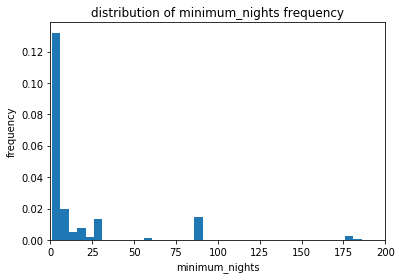

In [478]:
calculate_distribution(mn)
fitting_freq_curve(mn, 'minimum_nights', 'frequency',200,x_min=0,x_max=200,func=None)

Text(0.5, 1.0, 'domesitc distribution of minimum_nights')

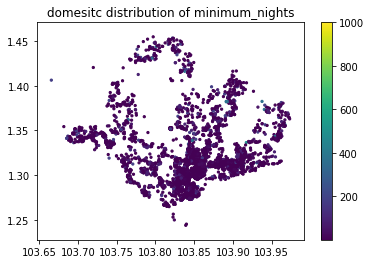

In [487]:
plt.scatter(lon, lat, c=mn, s=5)
plt.colorbar()
plt.title('domesitc distribution of minimum_nights')

mean value: 207.61019587495136
over average percentage: 54.91%
lower average percentage: 45.09%


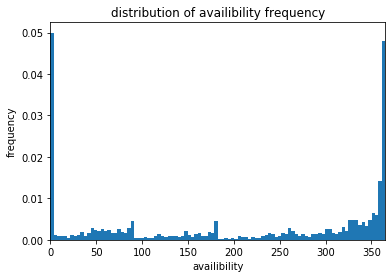

In [481]:
calculate_distribution(avl)
fitting_freq_curve(avl, 'availibility', 'frequency',100,func=None)

Text(0.5, 1.0, 'domesitc distribution of availibility_365')

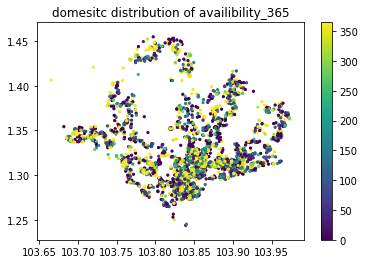

In [489]:
plt.scatter(lon, lat, c=avl, s=5)
plt.colorbar()
plt.title('domesitc distribution of availibility_365')

mean value: 40.90789985730964
over average percentage: 28.01%
lower average percentage: 71.99%


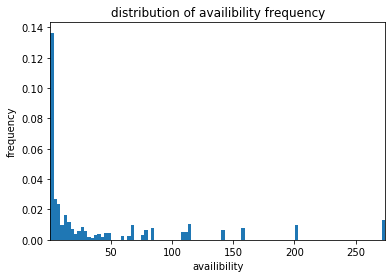

In [554]:
host = sp_data['calculated_host_listings_count'].values
calculate_distribution(host)
fitting_freq_curve(host, 'availibility', 'frequency',100,func=None)

Text(0.5, 1.0, 'domesitc distribution of host_listings_count')

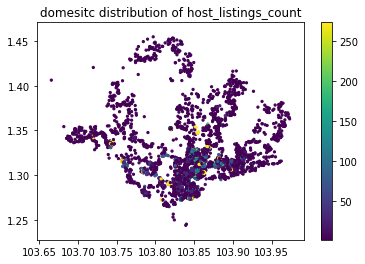

In [491]:
plt.scatter(lon, lat, c=host, s=5)
plt.colorbar()
plt.title('domesitc distribution of host_listings_count')

## Feature Correlation

In [502]:
sp_feature = sp_data[['latitude','longitude','calculated_host_listings_count','minimum_nights','availability_365','price']]
sp_feature.head()

,latitude,longitude,calculated_host_listings_count,minimum_nights,availability_365,price
0,1.44255,103.79580,2,180,365,83
1,1.33235,103.78521,1,90,365,81
2,1.44246,103.79667,2,6,365,69
3,1.34541,103.95712,9,1,353,206
4,1.34567,103.95963,9,1,355,94


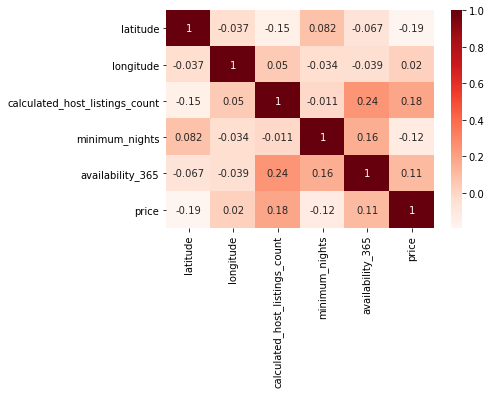

In [503]:
#plt.figure(figsize=(12,10))
cor = sp_feature.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [542]:
def separate_dict(f1_f2, bins=100):
    keys, values = [], []
    batch = len(f1_f2)//bins
    f1, f2 = f1_f2.keys(), f1_f2.values()
    f1_sort = sorted(f1)
    for i in range(bins):
        f1_gap = f1_sort[i*batch:(i+1)*batch]
        f2_gap = [f1_f2[x] for x in f1_gap]
        keys.append(np.mean(f1_gap))
        values.append(np.mean(f2_gap))
        
    return keys, values

Text(0, 0.5, 'average price')

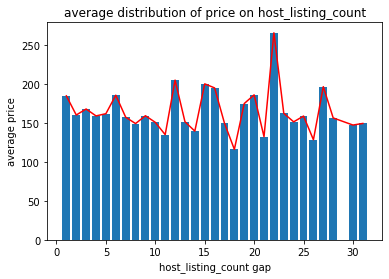

In [570]:
# average to ensure one x exactly correspond to one y
host_price = sp_data.groupby(['calculated_host_listings_count']).price.unique().agg(dict)
host_price_average = defaultdict(int)
for host in host_price.keys():
    host_price_average[host] = np.mean(host_price[host])
    
ave_host, ave_price = separate_dict(host_price_average, bins=30)
plt.bar(ave_host, ave_price)
plt.plot(ave_host, ave_price,color='r')
plt.title('average distribution of price on host_listing_count')
plt.xlabel('host_listing_count gap')
plt.ylabel('average price')

Text(0.5, 0, 'average price')

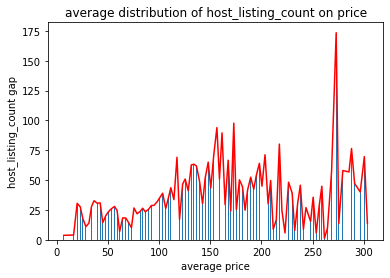

In [571]:
# average to ensure one x exactly correspond to one y
price_host = sp_data.groupby(['price']).calculated_host_listings_count.unique().agg(dict)
price_host_average = defaultdict(int)
for price in price_host.keys():
    price_host_average[price] = np.mean(price_host[price])
    
ave_price, ave_host = separate_dict(price_host_average, bins=100)
plt.bar(ave_price, ave_host)
plt.plot(ave_price,ave_host, color='r')
plt.title('average distribution of host_listing_count on price')
plt.ylabel('host_listing_count gap')
plt.xlabel('average price')

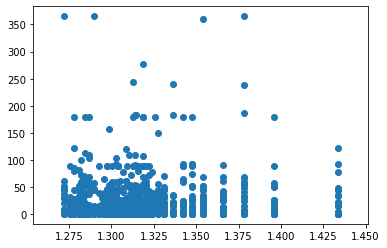

In [521]:
plt.scatter([x[0] for x in coordinate],gmn)

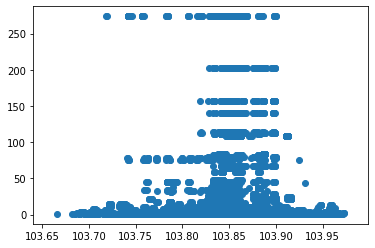

In [510]:
plt.scatter(lon,host)

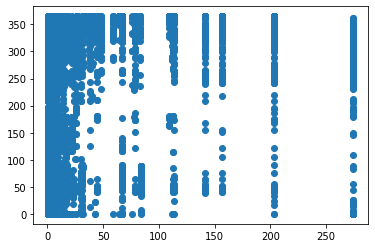

In [513]:
plt.scatter(host,avl)

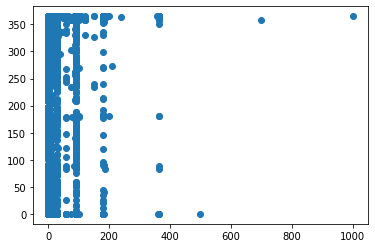

In [514]:
plt.scatter(mn,avl)

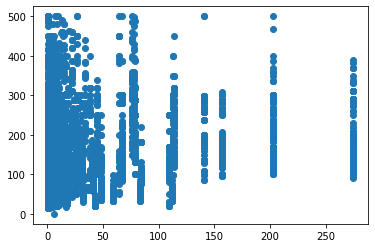

In [515]:
plt.scatter(host,price)

## Pretrain and evaulate the model

In [122]:
def segment_position(pos_min_nights, pos_host_own, pos_avail, pos_price, lat_bins, lon_bins):
    keys, gmn, gho, ga, values = [], [], [], [], []
    lat, lon = sorted([x[0] for x in pos_price.keys()]), sorted([x[1] for x in pos_price.keys()])
    batch_lat, batch_lon = len(pos_price)//lat_bins, len(pos_price)//lon_bins
    for i in tqdm_notebook(range(lat_bins)):
        lat_gap = lat[i*batch_lat: (i+1)*batch_lat]
        ave_lat = np.mean(lat_gap)
        for j in range(lon_bins):
            lon_gap = lon[j*batch_lon: (j+1)*batch_lon]
            ave_lon = np.mean(lon_gap)
            ave_values, ave_pmn, ave_pnr, ave_par, ave_pho, ave_pa = [], [], [], [], [], []
            for m in range(batch_lat):
                for n in range(batch_lon):
                    if (lat_gap[m], lon_gap[n]) in pos_price.keys():
                        price_list = pos_price[(lat_gap[m], lon_gap[n])]
                        pmn = pos_min_nights[(lat_gap[m], lon_gap[n])]
                        pho = pos_host_own[(lat_gap[m], lon_gap[n])]
                        pa = pos_avail[(lat_gap[m], lon_gap[n])]
                        if len(price_list) == 1:
                            price = int(price_list)
                            min_nights = int(pmn)
                            host_own = int(pho)
                            avail = int(pa)
                        else:
                            price = int(np.mean(price))
                            min_nights = int(np.mean(pmn))
                            host_own = int(np.mean(pho))
                            avail = int(np.mean(pa))

                        ave_values.append(price)
                        ave_pmn.append(min_nights)
                        ave_pho.append(host_own)
                        ave_pa.append(avail)
            if ave_values != []:
                values.append(np.mean(ave_values))
                gmn.append(np.mean(ave_pmn))
                gho.append(np.mean(ave_pho))
                ga.append(np.mean(ave_pa))
                keys.append([ave_lat, ave_lon])
    return keys, gmn, gho, ga, values    

In [123]:
def get_pos_price(sp_data):
    lat = sp_data['latitude'].values
    lon = sp_data['longitude'].values
    min_nights = sp_data['minimum_nights'].values
    host_own = sp_data['calculated_host_listings_count'].values
    avail = sp_data['availability_365'].values
    price = sp_data['price'].values
    pos_price = sp_data.groupby(['latitude','longitude']).price.unique().agg(dict)
    X_cor = np.array(list(zip(lat,lon)))
    pos_min_nights = sp_data.groupby(['latitude','longitude']).minimum_nights.unique().agg(dict)
    pos_host_own = sp_data.groupby(['latitude','longitude']).calculated_host_listings_count.unique().agg(dict)
    pos_avail = sp_data.groupby(['latitude','longitude']).availability_365.unique().agg(dict)
    y = price.copy()
    
    return X_cor, y, pos_min_nights, pos_host_own, pos_avail, pos_price

In [124]:
from scipy.spatial import cKDTree
from scipy import inf
from collections import defaultdict

class PointPrediction:
    def __init__(self, r0, coordinate, cor_price):
        self.r = r0
        self.grid_cor = coordinate
        self.grid_price = cor_price
        
    def get_nearest_grid(self, X):
        nearest_grid = defaultdict(int)
        for point in X:
            grid_dis = np.linalg.norm(self.grid_cor-point,axis=1)
            grid_index = np.argmin(grid_dis)
            nearest_grid[str(point)] = grid_index
        return nearest_grid
        
    def score(self, X, y):
        tree = cKDTree(X)
        nearest_grid_train = self.get_nearest_grid(X)
        predict = []
        
        for point in X:
            grid_index = nearest_grid_train[str(point)]
            predict.append(self.grid_price[grid_index])
                
        MSE = ((np.array(predict)-y)**2).mean()    
        return predict, MSE

In [228]:
class TrainRegressor:
    def __init__(self, lr, lamda, max_epoch, seg_part):
        self.lr = lr
        self.p = lamda
        self.epo = max_epoch
        self.seg = seg_part
        self.lnr()
        self.svm()
        self.rf()
        self.mlp()
        
    def lnr(self):
        self.clf1 = LinearRegression()
        
    def svm(self):
        self.clf2 = SVR(kernel = 'sigmoid', C=1.0, epsilon=0.2)
        
    def rf(self):
        self.clf3 = RandomForestRegressor(random_state=4)
        
    def mlp(self):
        self.clf4 = MLPRegressor(hidden_layer_sizes = (100,3), learning_rate = 'adaptive')  
        
    def fit_models(self, X ,y):
        self.clf.fit(X, y)
        
    def predict(self, X_test, y_test):
        y_pred = self.clf.predict(X_test)
        return y_pred
        
    def get_data(self, Xcor, pmn, gmn, pho, gho, pa, ga, nearest_grid, predict_price):
        self.ave = predict_price.copy()
        X = []
        for i in range(len(Xcor)):
            point = tuple(Xcor[i])
            grid_index = nearest_grid[str(point)]
            ave = predict_price[i]
            min_nights = pmn[point][0]-gmn[grid_index]
            hoster = pho[point][0]-gho[grid_index]
            avail = pa[point][0]-ga[grid_index]
            X.append([ave, min_nights, hoster, avail])
        X = np.array(X)
        return X
    
    def fit(self, train_sp, test_sp, record_metrics):
        self.mse_test = []
        Xcor_train, y_train, pmn_train, pho_train, pa_train, pos_price_train = get_pos_price(train_sp)
        coordinate, gmn, gho, ga, cor_price = segment_position(pmn_train, pho_train, pa_train, 
                                                               pos_price_train, self.seg, self.seg)
        pospre = PointPrediction(0.03, coordinate, cor_price)
        nearest_grid_train = pospre.get_nearest_grid(Xcor_train)
        predict_price_train, mse_train = pospre.score(Xcor_train, y_train)

        Xtrain = self.get_data(Xcor_train, pmn_train, gmn, pho_train, gho, pa_train, ga, nearest_grid_train, 
                               predict_price_train)
        
        Xcor_test, y_test, pmn_test, pho_test, pa_test, pos_price_test = get_pos_price(test_sp)
        nearest_grid_test = pospre.get_nearest_grid(Xcor_test)
        predict_price_test, mse_test = pospre.score(Xcor_test, y_test)
        
        Xtest = self.get_data(Xcor_test, pmn_test, gmn, pho_test, gho, pa_test, ga, nearest_grid_test, predict_price_test)
        
        self.clf = self.clf1
        self.fit_models(Xcor_train, y_train)
        y_pred = self.predict(Xcor_test, y_test)
        print(f'baseline test mse: {mse(y_test, y_pred)}, baseline test R2: {r2_score(y_test, y_pred)}')
        record_metrics['baseline mse'].append(mse(y_test, y_pred)) 
        record_metrics['baseline R2'].append(r2_score(y_test, y_pred))
        
        print(f'initial test mse: {mse_test}, initial test R2: {r2_score(y_test, predict_price_test)}\n')
        record_metrics['strong baseline mse'].append(mse_test) 
        record_metrics['strong baseline R2'].append(r2_score(y_test, predict_price_test))
        
        clf = [self.clf1, self.clf2, self.clf3, self.clf4]
        names = ["Linear Regression", "SVM", "Random Forest", "Multi-layer Perceptron"]
        for i in range(len(clf)):
            self.clf = clf[i]
            self.fit_models(coordinate, cor_price)
            y_pred = self.predict(Xcor_test, y_test)
            if i == 0:
                record_metrics['LR mse'].append(mse(y_test, y_pred)) 
                record_metrics['LR R2'].append(r2_score(y_test, y_pred))
            elif i == 1:
                record_metrics['SVM mse'].append(mse(y_test, y_pred)) 
                record_metrics['SVM R2'].append(r2_score(y_test, y_pred))
            elif i == 2:
                record_metrics['RF mse'].append(mse(y_test, y_pred)) 
                record_metrics['RF R2'].append(r2_score(y_test, y_pred))
            else:
                record_metrics['MLP mse'].append(mse(y_test, y_pred)) 
                record_metrics['MLP R2'].append(r2_score(y_test, y_pred))
                
            print(f'Model: {names[i]}, test MSE: {mse(y_test, y_pred)}, test R2: {r2_score(y_test, y_pred)}')
    
        self.mn_bias = defaultdict(int)
        self.ho_bias = defaultdict(int)
        self.av_bias = defaultdict(int)
        
        for e in range(self.epo):
            for i in range(len(Xtrain)):
                point = str(Xcor_train[i])
                ave, mb, hb, av = Xtrain[i][0], Xtrain[i][1], Xtrain[i][2], Xtrain[i][3]
                grid_index = nearest_grid_train[point]
                diff = ave+self.mn_bias[grid_index]*mb+self.ho_bias[grid_index]*hb+self.av_bias[grid_index]*av-y_train[i]
                
                self.mn_bias[grid_index] -= self.lr*(2*mb*diff + self.p*self.mn_bias[grid_index])
                self.ho_bias[grid_index] -= self.lr*(2*hb*diff + self.p*self.ho_bias[grid_index])
                self.av_bias[grid_index] -= self.lr*(2*av*diff + self.p*self.av_bias[grid_index])
                
            MSE_test, self.test_predict = self.mse(Xtest, Xcor_test, nearest_grid_test, y_test)
            hlr_r2 = r2_score(y_test, self.test_predict)
            if self.mse_test != [] and MSE_test > self.mse_test[-1]:
                print(f'Model: Hierarchical LinearRegressor, test MSE: {MSE_test}, test R2: {hlr_r2}')
                break
            self.mse_test.append(MSE_test)
        
        record_metrics['HLR mse'].append(MSE_test) 
        record_metrics['HLR R2'].append(hlr_r2)
        
            
    def mse(self, X, Xcor, nearest_grid, y):
        predict = []
        for i in range(len(X)):
            point = str(Xcor[i])
            ave, mb, hb, av = X[i][0], X[i][1], X[i][2], X[i][3]
            grid_index = nearest_grid[point]
            res = ave+self.mn_bias[grid_index]*mb+self.ho_bias[grid_index]*hb+self.av_bias[grid_index]*av
            predict.append(res)
            
        MSE = ((np.array(predict)-y)**2).mean() 
        return MSE, predict

In [229]:
import warnings
warnings.filterwarnings("ignore")
record_metrics = defaultdict(list)

for i in range(10):
    train_sp, test_sp = train_test_split(sp_data, test_size=1/20)

    lr = 1.0e-6
    max_epoch = 20
    lamda = 10
    seg_part = 50

    lrg = TrainRegressor(lr, lamda, max_epoch, seg_part)
    lrg.fit(train_sp, test_sp, record_metrics)

baseline test mse: 9390.128401823635, baseline test R2: 0.02880346286017932
initial test mse: 8780.05663004851, initial test R2: 0.09190159813591081

Model: Linear Regression, test MSE: 9458.5198335104, test R2: 0.02172991511068101
Model: SVM, test MSE: 9798.3660414116, test R2: -0.01341949351824101
Model: Random Forest, test MSE: 7937.221841702824, test R2: 0.17907380630969183
Model: Multi-layer Perceptron, test MSE: 9690.549183073534, test R2: -0.0022682765186003984
Model: Hierarchical LinearRegressor, test MSE: 8355.843739761543, test R2: 0.13577683310892397


baseline test mse: 9314.790641032025, baseline test R2: 0.029064370813658313
initial test mse: 9943.84026401711, initial test R2: -0.036505185714214905

Model: Linear Regression, test MSE: 9339.352836495937, test R2: 0.026504108149042138
Model: SVM, test MSE: 9972.447019185694, test R2: -0.0394870367185991
Model: Random Forest, test MSE: 8378.135630425328, test R2: 0.12669745319855596
Model: Multi-layer Perceptron, test MSE: 9600.09268445729, test R2: -0.0006743457841167366
Model: Hierarchical LinearRegressor, test MSE: 9198.961139585828, test R2: 0.04113796368321776


baseline test mse: 8406.370025127902, baseline test R2: 0.004380576420518256
initial test mse: 7158.362638200533, initial test R2: 0.15218996281219765

Model: Linear Regression, test MSE: 8496.71481809639, test R2: -0.006319527242516276
Model: SVM, test MSE: 8670.241554404145, test R2: -0.02687139310874964
Model: Random Forest, test MSE: 6804.015902397793, test R2: 0.19415748170473268
Model: Multi-layer Perceptron, test MSE: 27921.013856893627, test R2: -2.3068617773022906
Model: Hierarchical LinearRegressor, test MSE: 6609.046476618669, test R2: 0.217248940530551


baseline test mse: 8718.321330482346, baseline test R2: 0.05296243111245025
initial test mse: 7472.655082105425, initial test R2: 0.18827434389817532

Model: Linear Regression, test MSE: 8680.422681341746, test R2: 0.05707921497320856
Model: SVM, test MSE: 9495.310466321243, test R2: -0.031438897350192896
Model: Random Forest, test MSE: 7176.405819719987, test R2: 0.22045475691567895
Model: Multi-layer Perceptron, test MSE: 9218.948519967122, test R2: -0.001418766652193204
Model: Hierarchical LinearRegressor, test MSE: 7353.689996706749, test R2: 0.20119706158518547


baseline test mse: 8465.995889225189, baseline test R2: 0.05593671278216028
initial test mse: 7898.891881947159, initial test R2: 0.11917582609034116

Model: Linear Regression, test MSE: 8512.726880012326, test R2: 0.050725629130017325
Model: SVM, test MSE: 9006.8796502632, test R2: -0.004378518660153485
Model: Random Forest, test MSE: 7210.149459673039, test R2: 0.19597912764238
Model: Multi-layer Perceptron, test MSE: 9030.519366629142, test R2: -0.007014639517444632
Model: Hierarchical LinearRegressor, test MSE: 7462.976154790645, test R2: 0.16778582303743372


baseline test mse: 8357.808181246648, baseline test R2: 0.04926889765971898
initial test mse: 7626.0092098629, initial test R2: 0.13251369434173343

Model: Linear Regression, test MSE: 8506.151146511711, test R2: 0.03239434540481878
Model: SVM, test MSE: 8902.998416810593, test R2: -0.01274847608258578
Model: Random Forest, test MSE: 7468.357733074231, test R2: 0.15044712366464819
Model: Multi-layer Perceptron, test MSE: 27502.838827415388, test R2: -2.1285480246539366
Model: Hierarchical LinearRegressor, test MSE: 7110.025577574995, test R2: 0.19120871065179323


baseline test mse: 9934.235550698559, baseline test R2: 0.01994342573277441
initial test mse: 8823.845049429816, initial test R2: 0.12948839325629835

Model: Linear Regression, test MSE: 9971.560677783353, test R2: 0.016261135736918675
Model: SVM, test MSE: 10446.939200129535, test R2: -0.030637072355001793
Model: Random Forest, test MSE: 8152.396698281029, test R2: 0.1957297630593311
Model: Multi-layer Perceptron, test MSE: 10149.215034051016, test R2: -0.0012652576044482888
Model: Hierarchical LinearRegressor, test MSE: 8386.733500653518, test R2: 0.17261139400256287


baseline test mse: 8561.11113965382, baseline test R2: 0.04366735014060796
initial test mse: 9377.818282377246, initial test R2: -0.047564231043066396

Model: Linear Regression, test MSE: 8582.52761515415, test R2: 0.04127498839786492
Model: SVM, test MSE: 9109.729348123083, test R2: -0.01761692669074466
Model: Random Forest, test MSE: 8510.697607522245, test R2: 0.049298874598788456
Model: Multi-layer Perceptron, test MSE: 8957.31903147475, test R2: -0.0005916878393188441
Model: Hierarchical LinearRegressor, test MSE: 8915.092381100008, test R2: 0.004125307862385741


baseline test mse: 8316.980113733092, baseline test R2: 0.06062359298924036
initial test mse: 8388.86301317305, initial test R2: 0.05250464850722536

Model: Linear Regression, test MSE: 8331.38673239586, test R2: 0.05899641130892619
Model: SVM, test MSE: 9151.255935880828, test R2: -0.033605203226231506
Model: Random Forest, test MSE: 7492.971229132007, test R2: 0.15369277131796866
Model: Multi-layer Perceptron, test MSE: 8859.882439027624, test R2: -0.0006954950353734723
Model: Hierarchical LinearRegressor, test MSE: 7741.160251156402, test R2: 0.12566061197880862


baseline test mse: 7809.3259885496755, baseline test R2: 0.07360670762987498
initial test mse: 8714.906283157427, initial test R2: -0.03381914600425984

Model: Linear Regression, test MSE: 7956.936449030234, test R2: 0.056096189990663015
Model: SVM, test MSE: 8601.176065303154, test R2: -0.02032772419468598
Model: Random Forest, test MSE: 8164.368387477538, test R2: 0.031489257627656086
Model: Multi-layer Perceptron, test MSE: 28195.542550013888, test R2: -2.3447395500415364
Model: Hierarchical LinearRegressor, test MSE: 8583.44563994471, test R2: -0.018224425248398513


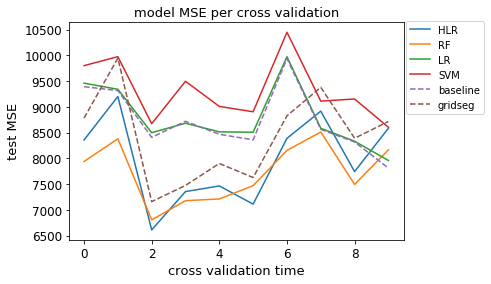

In [290]:
plt.plot(record_metrics['HLR mse'], label='HLR')
plt.plot(record_metrics['RF mse'], label='RF')
plt.plot(record_metrics['LR mse'], label='LR')
plt.plot(record_metrics['SVM mse'], label='SVM')

plt.plot(record_metrics['baseline mse'], label='baseline', linestyle='--')
plt.plot(record_metrics['strong baseline mse'], label='gridseg',linestyle='--')

plt.legend(loc='upper right',bbox_to_anchor=(1.255, 1.03))
plt.title('model MSE per cross validation',fontsize=13)
plt.xlabel('cross validation time',fontsize=13)
x = plt.xticks(fontsize=12)
plt.ylabel('test MSE',fontsize=13)
y = plt.yticks(fontsize=12)

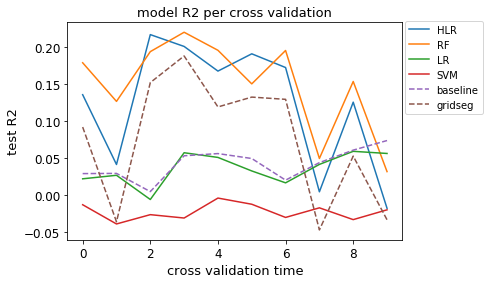

In [291]:
plt.plot(record_metrics['HLR R2'], label='HLR')
plt.plot(record_metrics['RF R2'], label='RF')
plt.plot(record_metrics['LR R2'], label='LR')
plt.plot(record_metrics['SVM R2'], label='SVM')

plt.plot(record_metrics['baseline R2'], label='baseline', linestyle='--')
plt.plot(record_metrics['strong baseline R2'], label='gridseg',linestyle='--')

plt.legend(loc='upper right',bbox_to_anchor=(1.255, 1.03))
plt.title('model R2 per cross validation',fontsize=13)
plt.xlabel('cross validation time',fontsize=13)
x = plt.xticks(fontsize=12)
plt.ylabel('test R2',fontsize=13)
y = plt.yticks(fontsize=12)

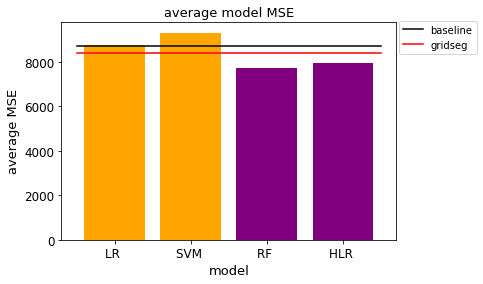

In [373]:
mse_average_list = []
model_list = []

for key in record_metrics.keys():
    if key.endswith('mse'):
        if key.startswith(('strong','baseline','MLP')) :
            continue
        mse_average_list.append(np.mean(record_metrics[key]))
        model_list.append(key.rstrip('mse'))
        
color_index = np.where(mse_average_list < np.mean(record_metrics['strong baseline mse']))[0]
color_control = np.array(['orange']*len(mse_average_list))
color_control[color_index] = 'purple'
color_control = tuple(list(color_control))
        
plt.bar(model_list,mse_average_list,color=color_control)
plt.plot(np.arange(-0.5,4.5),[np.mean(record_metrics['baseline mse'])]*5,color='black',label='baseline')
plt.plot(np.arange(-0.5,4.5),[np.mean(record_metrics['strong baseline mse'])]*5,color='red',label='gridseg')
plt.legend(loc='upper right',bbox_to_anchor=(1.255, 1.03))              
plt.title('average model MSE',fontsize=13)
plt.xlabel('model',fontsize=13)
x = plt.xticks(fontsize=12)
plt.ylabel('average MSE',fontsize=13)
y = plt.yticks(fontsize=12)

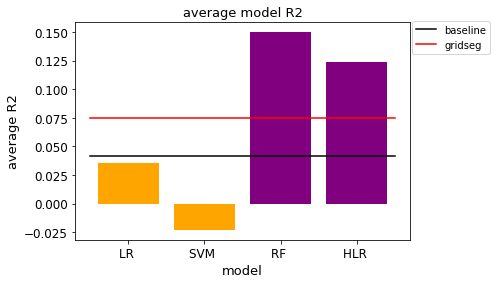

In [374]:
R2_average_list = []
model_list = []

for key in record_metrics.keys():
    if key.endswith('R2'):
        if key.startswith(('strong','baseline','MLP')):
            continue
        R2_average_list.append(np.mean(record_metrics[key]))
        model_list.append(key.rstrip('R2'))
               
color_index = np.where(R2_average_list > np.mean(record_metrics['strong baseline R2']))[0]
color_control = np.array(['orange']*len(R2_average_list))
color_control[color_index] = 'purple'
color_control = tuple(list(color_control))
        
plt.bar(model_list,R2_average_list,color=color_control)
plt.plot(np.arange(-0.5,4.5),[np.mean(record_metrics['baseline R2'])]*5,color='black',label='baseline')
plt.plot(np.arange(-0.5,4.5),[np.mean(record_metrics['strong baseline R2'])]*5,color='red',label='gridseg')
plt.legend(loc='upper right',bbox_to_anchor=(1.255, 1.03))                 
plt.title('average model R2',fontsize=13)
plt.xlabel('model',fontsize=13)
x = plt.xticks(fontsize=12)
plt.ylabel('average R2',fontsize=13)
y = plt.yticks(fontsize=12)